# Demonstration of HyPyP basics
Authors : Guillaume Dumas, Anaël Ayrolles, Florence Brun

Date : 2020-09-11

## Load useful libs

### Core

In [1]:
import io
from copy import copy
from collections import OrderedDict
import requests

### Data science

In [2]:
import numpy as np
import scipy

### Visualization

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

### MNE

In [4]:
import mne

### HyPyP

In [5]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

### Setting parameters
Frequency bands used in the study

In [6]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}
              
full_freq = { 'full_frq': [1, 48]}

Keep the order of frequency bands in the dictionary

In [7]:
freq_bands = OrderedDict(freq_bands)

### Load data
Loading datasets (see MNE functions mne.io.read_raw_format), convert them to MNE Epochs.

In our example, we load Epochs directly from EEG dataset in the fiff format

In [8]:
URL_TEMPLATE = "https://github.com/ppsp-team/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_data(idx):
    return io.BytesIO(requests.get(URL_TEMPLATE.format(idx)).content)

epo1 = mne.read_epochs(
    get_data(1),
    preload=True,
) 

epo2 = mne.read_epochs(
    get_data(2),
    preload=True,
)

Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [9]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Specify sampling frequency

In [10]:
sampling_rate = epo1.info['sfreq']

## Preprocessing epochs
## ICA correction

Computing global AutoReject and Independant Components Analysis for each participant

In [11]:
icas = prep.ICA_fit([epo1, epo2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state= 42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00010129807784293706}


/Users/gdumas/Scripts/HyPyP/hypyp/prep.py:220: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  icas.append(ica.fit(epoch_all_ch, reject=reject, tstep=1))


Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 4.747409473367548e-05}


/Users/gdumas/Scripts/HyPyP/hypyp/prep.py:220: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  icas.append(ica.fit(epoch_all_ch, reject=reject, tstep=1))


Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both

In [12]:
cleaned_epochs_ICA = prep.ICA_autocorrect(icas, [epo1, epo2])

/Users/gdumas/Scripts/HyPyP/hypyp/prep.py:153: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/Users/gdumas/Library/Caches/pypoetry/virtualenvs/hypyp-N9jtDCWH-py3.9/lib/python3.9/site-packages/mne_icalabel/iclabel/utils.py:139: RuntimeWarning: divide by zero encountered in log
  g = np.square(d) * (np.log(d) - 1)  # % Green's function.
/Users/gdumas/Library/Caches/pypoetry/virtualenvs/hypyp-N9jtDCWH-py3.9/lib/python3.9/site-packages/mne_icalabel/iclabel/utils.py:139: RuntimeWarning: invalid value encountered in multiply
  g = np.square(d) * (np.log(d) - 1)  # % Green's function.
/Users/gdumas/Scripts/HyPyP/hypyp/prep.py:153: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLab

For using PDC measure (Partial Coherence Connectivity), we should use the data that no ICA algorithm is applied on them.

In [13]:
# without ICA -> computing PDC based on MVARICA approach
cleaned_epochs_no_ICA = [epo1, epo2]

### Autoreject
Applying local AutoReject for each participant rejecting bad epochs, rejecting or interpolating partially bad channels removing the same bad channels and epochs across participants plotting signal before and after (verbose=True)

Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=1
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=1
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
8.333333333333332 percent of bad epochs


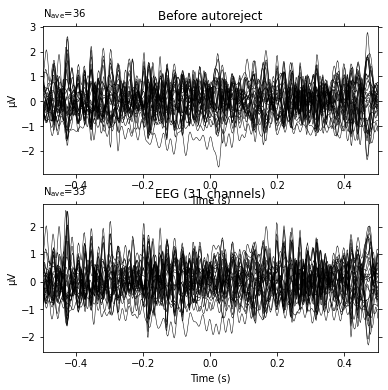

<Figure size 432x288 with 0 Axes>

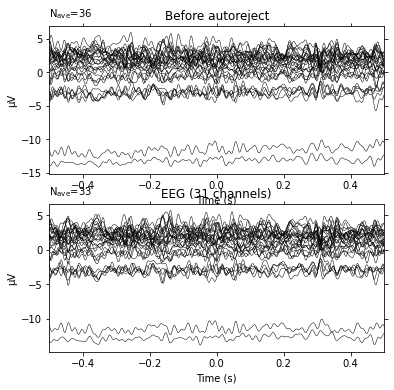

<Figure size 432x288 with 0 Axes>

In [14]:
# with ICA

cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=1
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs


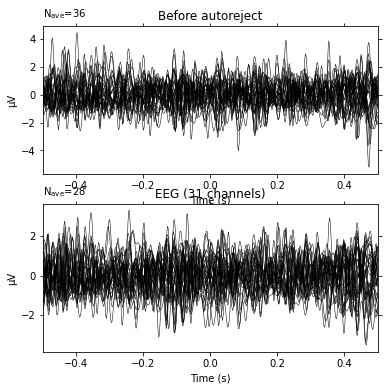

<Figure size 432x288 with 0 Axes>

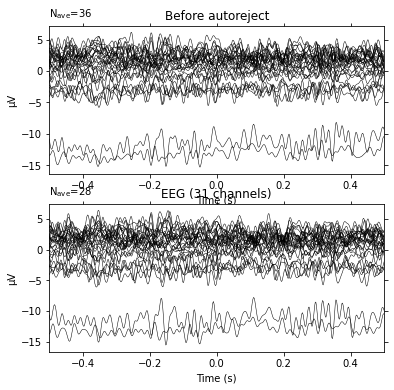

<Figure size 432x288 with 0 Axes>

In [15]:
# without ICA

no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)


### Picking the preprocessed epochs for each participant

In [16]:
# with ICA
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

In [17]:
# without ICA
no_ICA_preproc_S1 = no_ICA_cleaned_epochs_AR[0]
no_ICA_preproc_S2 = no_ICA_cleaned_epochs_AR[1]

## Analysing data
### Welch Power Spectral Density
Here for ex, the frequency-band-of-interest is restricted to Alpha_Low, frequencies for which power spectral density is actually computed are returned in freq_list, and PSD values are averaged across epochs

In [18]:
# with ICA

psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])

In [19]:
# without ICA

no_ICA_psd1 = analyses.pow(no_ICA_preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_psd2 = analyses.pow(no_ICA_preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_data_psd = np.array([no_ICA_psd1.psd, no_ICA_psd2.psd])

### Connectivity
Initializing data and storage

In [20]:
# with ICA
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

In [21]:
# without ICA
no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])

Computing analytic signal per frequency band

In [22]:
# with ICA
complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate,
                                             freq_bands)

/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data

In [23]:
# without ICA
no_ICA_complex_signal = analyses.compute_freq_bands(no_ICA_data_inter, sampling_rate,
                                             full_freq)

/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (1651) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:692: RuntimeWarning: filter_length (1651) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],


Computing frequency- and time-frequency-domain connectivity, 'ccorr' for example

In [24]:
result = analyses.compute_sync(complex_signal, mode='ccorr')

Slicing results to get the Inter-brain part of the matrix

In [25]:
n_ch = len(epo1.info['ch_names'])
theta, alpha_low, alpha_high, beta, gamma = result[:, 0:n_ch, n_ch:2*n_ch]


Choosing Alpha_Low for futher analyses for example

In [26]:
values = alpha_low

Computing Cohens'D for further analyses for example

In [27]:
C = (values - np.mean(values[:])) / np.std(values[:])

Slicing results to get the Intra-brain part of the matrix

In [28]:
for i in [0, 1]:
    theta, alpha_low, alpha_high, beta, gamma = result[:, (
        i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
    # choosing Alpha_Low for futher analyses for example
    values_intra = alpha_low
    values_intra -= np.diag(np.diag(values_intra))
    # computing Cohens'D for further analyses for example
    C_intra = (values_intra -
               np.mean(values_intra[:])) / np.std(values_intra[:])
    # can also sample CSD values directly for statistical analyses
    result_intra.append(C_intra)


Computing frequency- and time-frequency-domain connectivity measures obtained by MVARICA approach, based on MVAR models' coefficients. For instance: PDC measure, with MVAR model of order 2, extended infomax ICA method and checking the MVAR model stability.

In [36]:
PDC = analyses.compute_conn_mvar(no_ICA_complex_signal, 
                                 mvar_params={"mvar_order": 2, "fitting_method":"default", "delta": 0},
                                 ica_params={"method": "infomax_extended", "random_state": None},
                                 measure_params={"name": "pdc", "n_fft": 512}
                                 )

MVAR model is not stable: number of time samples may be too small


At least 7688 samples are required for fitting MVAR model


MVAR model is stable


/Users/gdumas/Scripts/HyPyP/hypyp/analyses.py:588: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(aux_3, dtype=d_type)


Slicing results to get the Inter-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

For further analysises in the tutorial, we keep the maximum connectivity values in the feequency spectrum, as it has been done in this [article](https://pubmed.ncbi.nlm.nih.gov/11417058/).

In [37]:
PDC

array([[[[[8.96191356e-01, 8.96088612e-01, 8.95779718e-01, ...,
           9.98886419e-01, 9.98886464e-01, 9.98886487e-01],
          [4.20930769e-02, 4.21116374e-02, 4.21673874e-02, ...,
           3.37761389e-03, 3.37754334e-03, 3.37750807e-03],
          [5.04488562e-02, 5.04675670e-02, 5.05237466e-02, ...,
           9.22208493e-03, 9.22189325e-03, 9.22179742e-03],
          ...,
          [9.38369180e-02, 9.38824835e-02, 9.40193237e-02, ...,
           2.85713565e-03, 2.85706800e-03, 2.85703417e-03],
          [5.96124326e-02, 5.96340749e-02, 5.96990793e-02, ...,
           1.34460058e-03, 1.34454803e-03, 1.34452176e-03],
          [1.07093956e-01, 1.07144035e-01, 1.07294466e-01, ...,
           2.26536692e-03, 2.26529804e-03, 2.26526360e-03]],

         [[6.80886415e-02, 6.81239241e-02, 6.82298738e-02, ...,
           8.62515340e-03, 8.62498101e-03, 8.62489482e-03],
          [9.23527358e-01, 9.23452904e-01, 9.23229020e-01, ...,
           9.99337219e-01, 9.99337246e-01, 9.993372

In [38]:
no_ICA_result_inter = []
for i in [0, 1]:
    PDC_q = PDC.squeeze()
    if i == 0 :
      mvar_spectrum =  PDC_q[n_ch:n_ch*2, 0:n_ch, :]
    else:
      mvar_spectrum =  PDC_q[0:n_ch, n_ch:n_ch*2, :]   
    PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
    for j in range(0, n_ch):
      for k in range(0, n_ch):
        PDC_fmax[j, k] = np.amax(mvar_spectrum[j,k,:])
    mvar_values_inter = PDC_fmax
    mvar_values_inter -= np.diag(np.diag(mvar_values_inter))
    # computing Cohens'D for further analyses for example
    mvar_C_inter = (mvar_values_inter -
               np.mean(mvar_values_inter[:])) / np.std(mvar_values_inter[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_inter.append(mvar_C_inter)

Slicing results to get the Intra-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

Again, we keep the maximum connectivity values in the feequency spectrum, as it has been done in the [article](https://pubmed.ncbi.nlm.nih.gov/11417058/).

In [39]:
no_ICA_result_intra = []
for i in [0, 1]:
    PDC = PDC.squeeze()
    mvar_spectrum =  PDC[i*n_ch:n_ch*(i+1), i*n_ch:n_ch*(i+1), :]
    # choosing the max values for futher analyses for example
    PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
    for j in range(0, n_ch):
      for k in range(0, n_ch):
        PDC_fmax[j, k] = np.amax(mvar_spectrum[j, k, :])
    mvar_values_intra = PDC_fmax
    mvar_values_intra -= np.diag(np.diag(mvar_values_intra))
    # computing Cohens'D for further analyses for example
    mvar_C_intra = (mvar_values_intra -
               np.mean(mvar_values_intra[:])) / np.std(mvar_values_intra[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_intra.append(mvar_C_intra)

In [40]:
no_ICA_result_intra[0].mean()

5.175649480042353e-17

In [41]:
no_ICA_result_intra[0].min()

-1.6636809050188008

In [42]:
no_ICA_result_intra[0].max()

4.659901950904734

## Statistical analyses
### Comparing PSD values to random signal
Parametric t test

#### 1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension


In [43]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)

In [44]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
i , u = X.shape

In [45]:
statsCondTuple = stats.statsCond(data=data_psd,
                                 epochs=preproc_S1,
                                 n_permutations=5000,
                                 alpha=0.05)

#### 3/ Non-parametric cluster-based permutations¶
Creating matrix of a priori connectivity between channels across space and frequencies based on their position, in the Alpha_Low band for example

In [46]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

Creating two fake groups with twice the 'participant1' and twice the 'participant1'

In [47]:
data_group = [np.array([psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd])]

statscondCluster = stats.statscondCluster(data=data_group,
                                          freqs_mean=psd1.freq_list,
                                          ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

/Users/gdumas/Scripts/HyPyP/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,
/Users/gdumas/Library/Caches/pypoetry/virtualenvs/hypyp-N9jtDCWH-py3.9/lib/python3.9/site-packages/mne/stats/parametric.py:170: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


### Comparing Intra-brain connectivity values between participants¶
With 3/ non-parametric cluster-based permutations creating matrix of a priori connectivity between channels across space and frequencies based on their position

In [48]:
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1, freqs_mean=np.arange(7.5, 11), draw=False)

Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [49]:
ch_con = con_matrixTuple.ch_con

Create again two fake groups with twice the 'participant1' and twice the 'participant2'

In Alpha_Low band for example (see above):

In [50]:
Alpha_Low = [np.array([result_intra[0], result_intra[0]]),
             np.array([result_intra[1], result_intra[1]])]

statscondCluster_intra = stats.statscondCluster(data=Alpha_Low,
                                                freqs_mean=np.arange(7.5, 11),
                                                ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
                                                tail=0,
                                                n_permutations=5000,
                                                alpha=0.05)

/Users/gdumas/Scripts/HyPyP/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,


### Comparing Inter-brain connectivity values to random signal¶
No a priori connectivity between channels is considered between the two participants

In Alpha_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [51]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=np.arange(7.5, 11),
                                          ch_con_freq=None,
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

/Users/gdumas/Scripts/HyPyP/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,


## Visualization

### Visualization of T values for sensors

for 1/ T_obs_plot = T_obs

for 2/ statsCondTuple.T_obs

for 3/ statscondCluster.F_obs_plot

In [52]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs, epochs=preproc_S1)

### Vizualize T values for significant sensors only

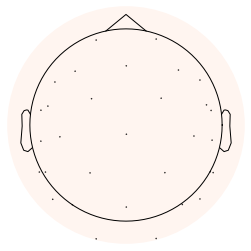

In [53]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot, epochs=preproc_S1)

### Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [54]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

### Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

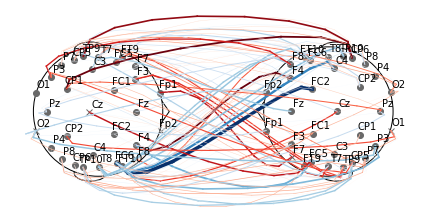

<AxesSubplot:>

In [55]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold='auto', steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

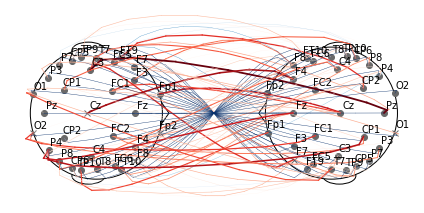

<AxesSubplot:>

In [56]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

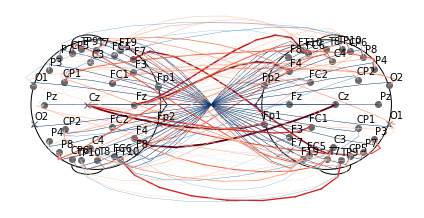

<AxesSubplot:>

In [57]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=True)

#### Visualization of inter-brain connectivity in 3D

Inter-brain Hilbert-based connectivity


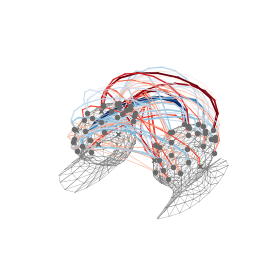

<Axes3DSubplot:>

In [58]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

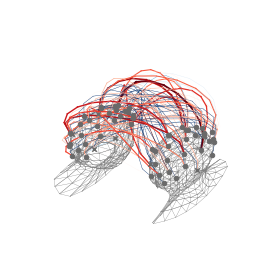

<Axes3DSubplot:>

In [59]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

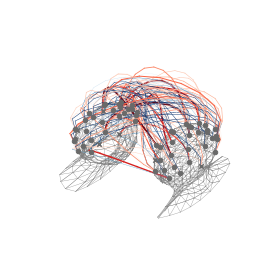

<Axes3DSubplot:>

In [60]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=False)

#### Visualization of intra-brain connectivity in 2D

Intra-brain Hilbert-based connectivity

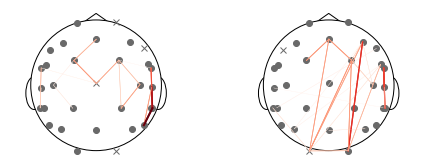

<AxesSubplot:>

In [61]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

Intra-brain VAR-based connectivity

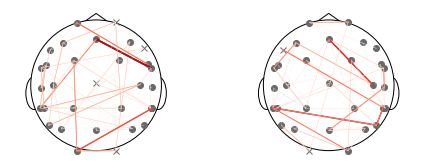

<AxesSubplot:>

In [62]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= no_ICA_result_intra[0],
                         C2= no_ICA_result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

#### Visualization of intra-brain connectivity in 3D

Intra-brain Hilbert-based connectivity

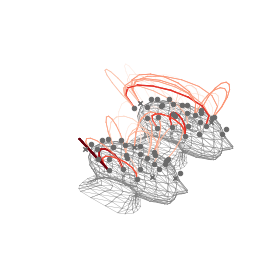

<Axes3DSubplot:>

In [63]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)

Intra-brain VAR-based connectivity

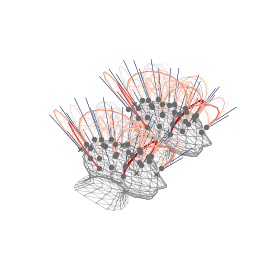

<Axes3DSubplot:>

In [64]:
viz.viz_3D_intra(epo1, epo2,
                 C1= no_ICA_result_intra[0],
                 C2= no_ICA_result_intra[0],
                 threshold='auto',
                 steps=10,
                 lab=False)